## Modeling a strong gravitational lens 

Before we continue: Please check if the following libraries are available on your computer:

* numpy: could be installed using pip3(or pip) install numpy
* matplotlib: could be installed using pip3 install matplotlib
* lenstronomy: could be installed using pip3 install lenstronomy
* PyAutoLens: Could be isntalled using pip3 install autolens==2022.03.18.2 (Keep in mind that you should have problems to install the latest version)

This example is based on [this](https://github.com/sibirrer/lenstronomy_extensions/blob/main/lenstronomy_extensions/Notebooks/simple_ring.ipynb ) lenstronomy usage example.

<img src="https://raw.githubusercontent.com/Jammy2211/PyAutoLens/master/docs/overview/images/lensing/schematic.jpg"  width="700" />

In [1]:
# Some basics libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import autolens to resize a psf (way more practical)
import autolens as al

# Import Lenstronomy modules
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from astropy.io import fits
import corner

# Also a magic function
%matplotlib inline

### Reading data and usefull constants

In [2]:
# Usefull constants
pixel_scale =  27.9/150 # It defines your pixel-arcseconds transformation (how much arcseconds we have in our cutout?
#In this case, 27.9 equals 150x150 pixels)
exposure_time = 1640.32 # Exposure time of our cutout, could be uselfull to define a noise map of our image
rms_background = 0.0426012 # Background rms subtracted, also usefull to estimate noise, here in ADUs

# general configurations
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=150, # horizontal (or vertical number of pixels) 
                                                                                        deltapix=pixel_scale, # pixel scale
                                                                                        center_ra=0, # lens ra position
                                                                                        center_dec=0, # lens dec position
                                                                                        subgrid_res=1, # resoluton factor of our images
                                                                                        inverse=False) # invert east to west?

In [3]:
# read our residual image
residual_image = fits.open('./data/211527.fits')[3].data
# read our psf and resize to an odd shape
psf = al.Kernel2D.from_fits(file_path='./data/psf.fits', hdu=0, pixel_scales=pixel_scale)
psf = al.preprocess.array_with_new_shape(array=psf, new_shape=(17, 17))
psf = psf.reshape(17, 17)

### Subtracted image

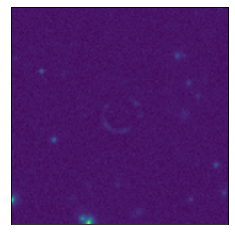

In [4]:
plt.imshow(residual_image)
plt.xticks([])
plt.yticks([]);

### Defining our model and priors

In [5]:
source_model = ['SERSIC_ELLIPSE'] # bulge for the source light
lens_model = ['SIE'] # mass distribution to our lens model. 
# if we were going to model the original image (with lens light), this would be a great moment to define a bulge for our lens, similar to the one defined to the source

# set our psf class
# psf input parameters
kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': pixel_scale, 'kernel_point_source': psf}
psf_class = PSF(**kwargs_psf)
# some fit parameters
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

In [6]:
# setting our image class
# data input parameters
kwargs_data = {'background_rms': rms_background,  # rms of background in ADUs
               'exposure_time': exposure_time,  # exposure time
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((150, 150))}  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.

data_class = ImageData(**kwargs_data) 
data_class.update_data(residual_image)
kwargs_data['image_data'] = residual_image

In [7]:
# setting our priors
######## Lens ########
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# initial guess, sigma, upper and lower parameters
fixed_lens.append({})
# initial guess
kwargs_lens_init.append({'theta_E': 2.3, 'e1': -0.04, 'e2': 0.16, 'center_x': -0.1, 'center_y': -0.08}) # Einstein radius, eccentricity and lens positions   
 # 1-sigma values  
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.01, 'e2': 0.02, 'center_x': 0.03, 'center_y': 0.05})                     
# upper and lower bounds
kwargs_lower_lens.append({'theta_E': 2., 'e1': -0.1, 'e2': -0.1, 'center_x': -0.5, 'center_y': -0.5})
kwargs_upper_lens.append({'theta_E': 3., 'e1': 0., 'e2': 0.2, 'center_x': 0.5, 'center_y': 0.5})

# intitial guess for the lens positions
fixed_lens.append({'ra_0': 0, 'dec_0': 0})
# gamma parameters, initial guess, sigma, upper and lower bounds
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

# creating an object to have all this attributes
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

######## Source ########
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# initial guess, sigma, upper and lower parameters
fixed_source.append({})
# initial guess
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0.1, 'e2': -0.1, 'center_x': 0.05, 'center_y': -0.2}) # R sersic parameter, n sersic index, eccentricities and x and y centers
 # 1-sigma values 
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.05, 'center_x': 0.02, 'center_y': 0.05}) # 1-sigma values
# upper and lower bounds
kwargs_lower_source.append({'e1': -1., 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -0.5, 'center_y': -0.5})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 0.5, 'center_y': 0.5})

# creating an object to have all this attributes
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# setting lens and source parameters (Einstein raidius, eccentricities, R sersic, etc)
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params}

### Fit our model

In [8]:
# Likelihood kwargs
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model, 'source_light_model_list': source_model} # Sersic, SIE, etc
# here, we have 1 single band to fit
multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]] # in this example, just a single band fit
# if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
# we dont have a constraint
kwargs_constraints = {}

In [9]:
# running an mcmc algorithm
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params) # setting our previous kwargs
fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]] # mcmc parameters
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list) # setting mcmc kwargs
kwargs_result = fitting_seq.best_fit() # store the best fit result
# besft fit chain
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]
n_sample = len(samples_mcmc)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]

2022-04-13 14:34:19,080 - lenstronomy.Sampling.Pool.pool - INFO - Running with SerialPool


100%|█████████████████████████████████████████| 800/800 [19:29<00:00,  1.46s/it]

Computing the MCMC...
Number of walkers =  110
Burn-in iterations:  200
Sampling iterations (in current run): 800
1170.7936351299286 time taken for MCMC sampling


### Visualize our results

/home/joao/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/joao/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)


-4.022596119706895 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  4.022596119706897


/home/joao/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:495: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
/home/joao/.local/lib/python3.8/site-packages/lenstronomy/Plots/model_band_plot.py:495: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


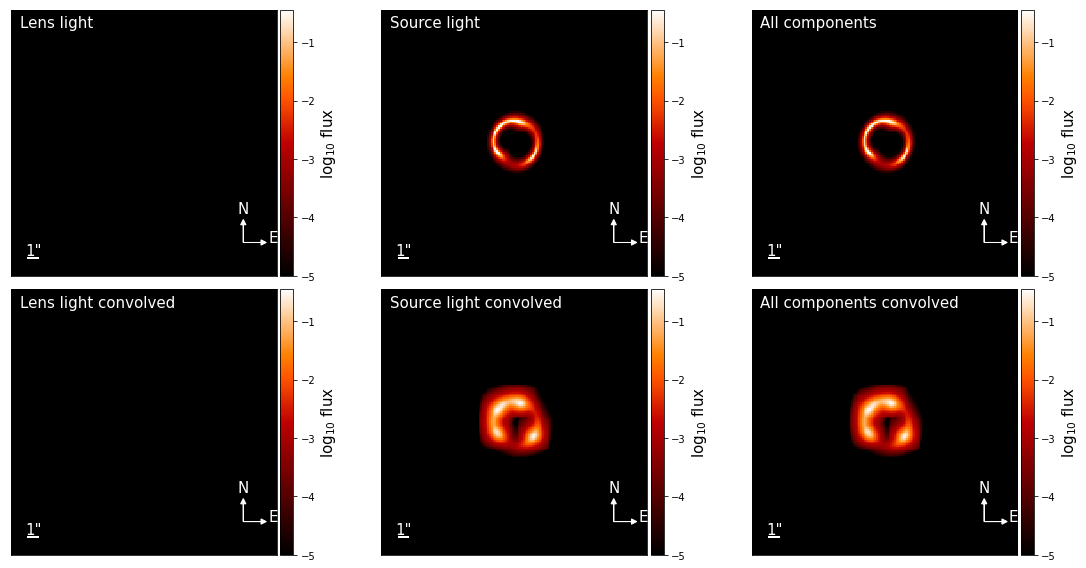

{'kwargs_lens': [{'theta_E': 2.249886052932493, 'e1': -0.0355647764775806, 'e2': 0.13751257961508706, 'center_x': 0.0117501312149444, 'center_y': 0.15491895735531766}], 'kwargs_source': [{'amp': 36.92029772298312, 'R_sersic': 0.04291843834523798, 'n_sersic': 2.3891448787042027, 'e1': -0.18647575132781827, 'e2': 0.1406907982787834, 'center_x': 0.15469430148218377, 'center_y': 0.07717369055458972}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [10]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

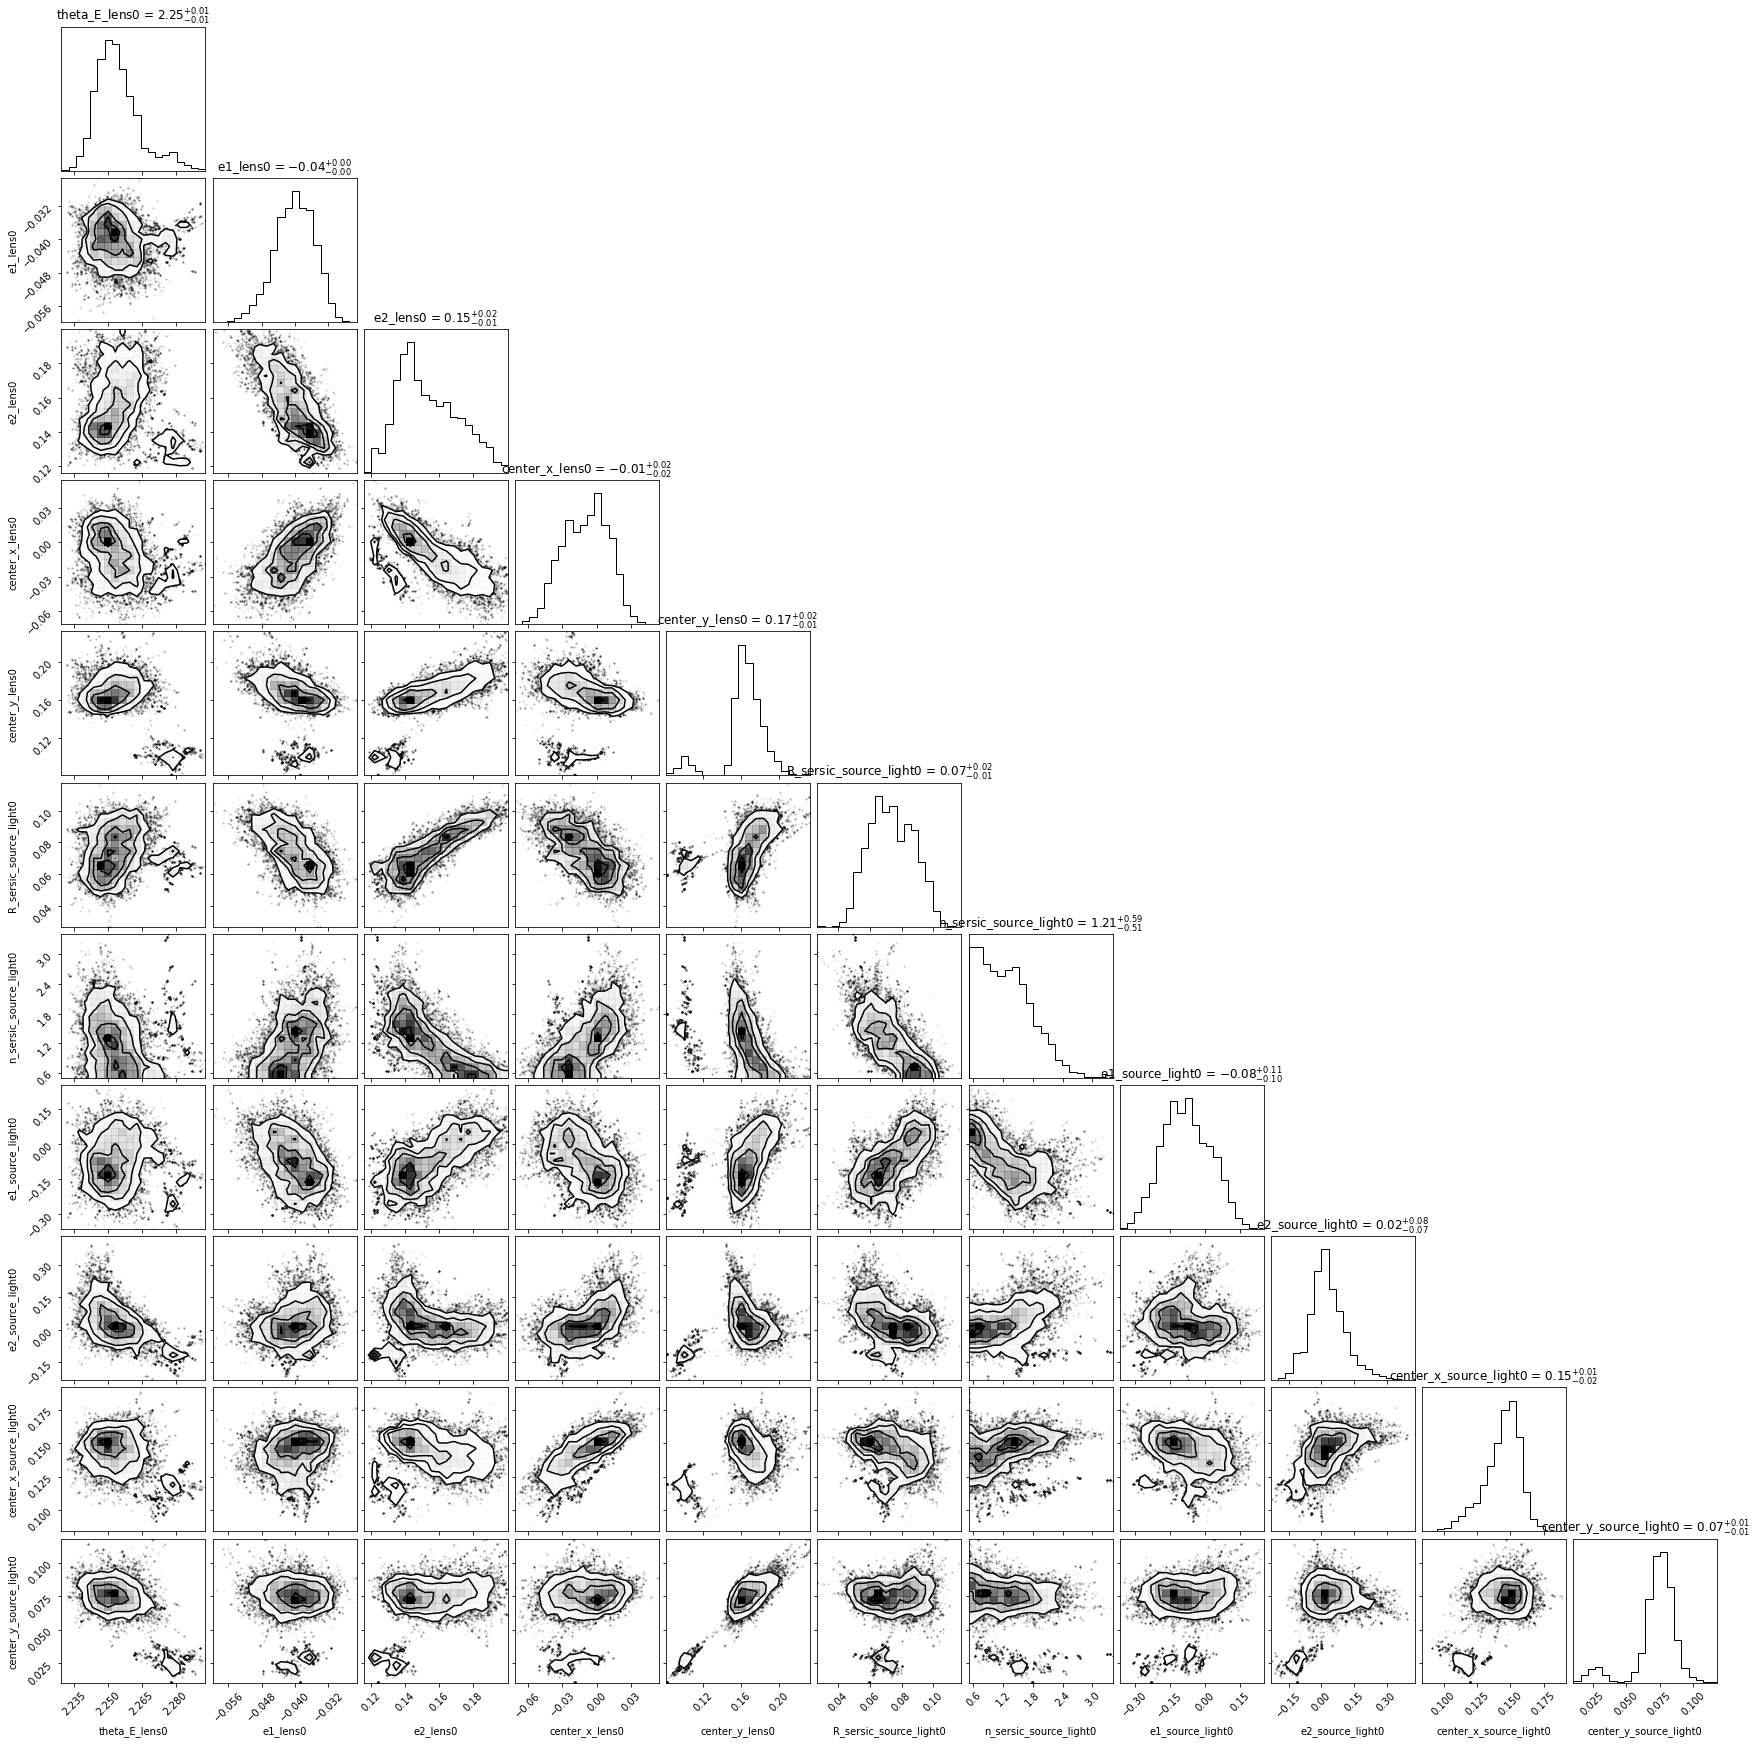

In [11]:
# sample and contour plots
plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True)